# Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 16
sns.set(style='whitegrid', palette='deep')

In [3]:
import h3
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np
import polars as pl

pl.set_random_seed(56)

In [5]:
import torch
from torch import nn
import pytorch_lightning
from transformers import ResNetConfig, ResNetModel, get_linear_schedule_with_warmup

pytorch_lightning.seed_everything(56, workers=True)

Global seed set to 56


56

# Data

Рекомедную вместо `Pandas` использовать библиотеку `Polars`, так как она мультипоточная $\Rightarrow$ быстрее.

### Load

In [6]:
with open("./data/hexses_target.lst", "r") as f:
    hexses_target = [x.strip() for x in f.readlines()]

In [7]:
with open("./data/hexses_data.lst", "r") as f:
    hexses_data = [x.strip() for x in f.readlines()]

In [8]:
transactions = pl.read_parquet("./data/transactions.parquet")
transactions = transactions.with_columns(
    std=pl.when(pl.col("count") >= 2).then(pl.col("std")).otherwise(0)
)
transactions

h3_09,customer_id,datetime_id,count,sum,avg,min,max,std,count_distinct,mcc_code
str,i64,i64,i64,f64,f64,f64,f64,f64,i64,i64
"""8911aa4c62ffff…",1,3,1,3346.65,3346.65,3346.65,3346.65,0.0,1,13
"""8911aa7b5b3fff…",4,3,1,450.0,450.0,450.0,450.0,0.0,1,8
"""8911aa63623fff…",5,3,10,11035.69,1103.569,59.0,3620.18,1190.530333,6,13
"""8911aa48577fff…",9,2,2,628.0,314.0,295.0,333.0,26.870058,2,5
"""8911aa78297fff…",11,2,1,4155.0,4155.0,4155.0,4155.0,0.0,1,10
"""8911aa78dc7fff…",12,2,2,94.0,47.0,47.0,47.0,0.0,2,9
"""8911aa4ec93fff…",13,3,25,9089.44,363.5776,176.99,707.96,162.457572,2,0
"""8911aa6a4c3fff…",15,1,10,1400.0,140.0,140.0,140.0,0.0,1,8
"""891181b6507fff…",16,2,1,10998.0,10998.0,10998.0,10998.0,0.0,1,10


In [9]:
target = pl.read_parquet("./data/target.parquet")
target

h3_09,customer_id
str,i64
"""8911aa6ac3bfff…",23172
"""8911aa7a857fff…",95640
"""8911aa70b97fff…",60350
"""8911aa70b97fff…",69521
"""891181b69abfff…",29437
"""8911aa44c2bfff…",24811
"""8911aa44c2bfff…",2641
"""8911aa44c2bfff…",67199
"""8911aa44c2bfff…",22852


### Split

In [10]:
ids = sorted(target["customer_id"].unique())
train_ids, val_ids = train_test_split(ids, train_size=0.7, random_state=56)
print(len(train_ids), len(val_ids))
train_target = target.filter(pl.col("customer_id").is_in(train_ids))
val_target = target.filter(pl.col("customer_id").is_in(val_ids))
print(len(train_target), len(val_target))

48535 20802
110442 47364


# Model

Будем подавать в модель матрицу с признаками, характеризующими транзакции в конкретной точке. Нужно перевести вещественные координаты на карте в целые индексы. Для этого придется их сжать, разделив на коэффициент, зависящий от итогового размера. После такого преобразования некоторые хексы склеятся (впрочем, различных координат слишком много, без объединения, будет проблематично вместить такую матрицу в видеопамять)

### Config

In [11]:
min_lat, max_lat = 55.1719, 56.0185
min_lon, max_lon = 36.8340, 37.9599
map_size = 128
lat_scale = (max_lat - min_lat) / (map_size - 1)
lon_scale = (max_lon - min_lon) / (map_size - 1)

num_workers = 0 # для Windows

### Prepare

In [12]:
# кодируем все хексы
items = sorted(set(hexses_target) | set(hexses_data))
item2id = {}
for item in items:
    item2id[item] = len(item2id)

In [13]:
items_target = [item2id[item] for item in hexses_target]

In [14]:
# получаем индексы (i, j) для матрицы
xs, ys = [], []
for item in items:
    lat, lon = h3.h3_to_geo(item)
    xs.append(round((lat - min_lat) / lat_scale))
    ys.append(round((lon - min_lon) / lon_scale))
assert np.max(xs) < map_size
assert np.max(ys) < map_size

### Dataset

In [15]:
class GeoDataset(torch.utils.data.Dataset):
    def __init__(self, pos_pairs, transactions):
        super().__init__()

        pos_pairs = pos_pairs.with_columns(pl.col("h3_09").map_dict(item2id, default=None))
        transactions = transactions.with_columns(pl.col("h3_09").map_dict(item2id, default=None))

        self._data = (
            transactions
            .filter(pl.col("customer_id").is_in(pos_pairs["customer_id"]))
            .group_by("customer_id", maintain_order=True)
            .agg(
                items=pl.col("h3_09"),
                counts=pl.col("count"),
            )
            .join(pos_pairs.group_by("customer_id").agg(labels=pl.col("h3_09")), on="customer_id", how="left")
        )

    def __len__(self):
        return len(self._data)

    def __getitem__(self, index):
        row = self._data.row(index)
        items = row[1]
        counts = row[2]
        labels = row[-1]

        pixel_values = torch.zeros((map_size, map_size, 3)).float()
        # 0: индикатор или "bias"
        # 1: количество групп из транзакций
        # 2: количество совершенных операций
        for i, item in enumerate(items):
            pixel_values[xs[item]][ys[item]][0] = 1.0
            pixel_values[xs[item]][ys[item]][1] += 1.0
            pixel_values[xs[item]][ys[item]][2] += counts[i]
        # прологарифмируем, так как некоторые пользователи совершают слишком много операций
        pixel_values[:, :, 2] = torch.log1p(pixel_values[:, :, 2])

        labels = torch.tensor(np.isin(items_target, labels, assume_unique=True, invert=False)).float()
        
        return pixel_values, labels

In [16]:
train_dataset = GeoDataset(train_target, transactions)

In [17]:
val_dataset = GeoDataset(val_target, transactions)

### Visualization

Посмотрим на матрицу для одного из пользователей, видно в каких точках было больше транзакций

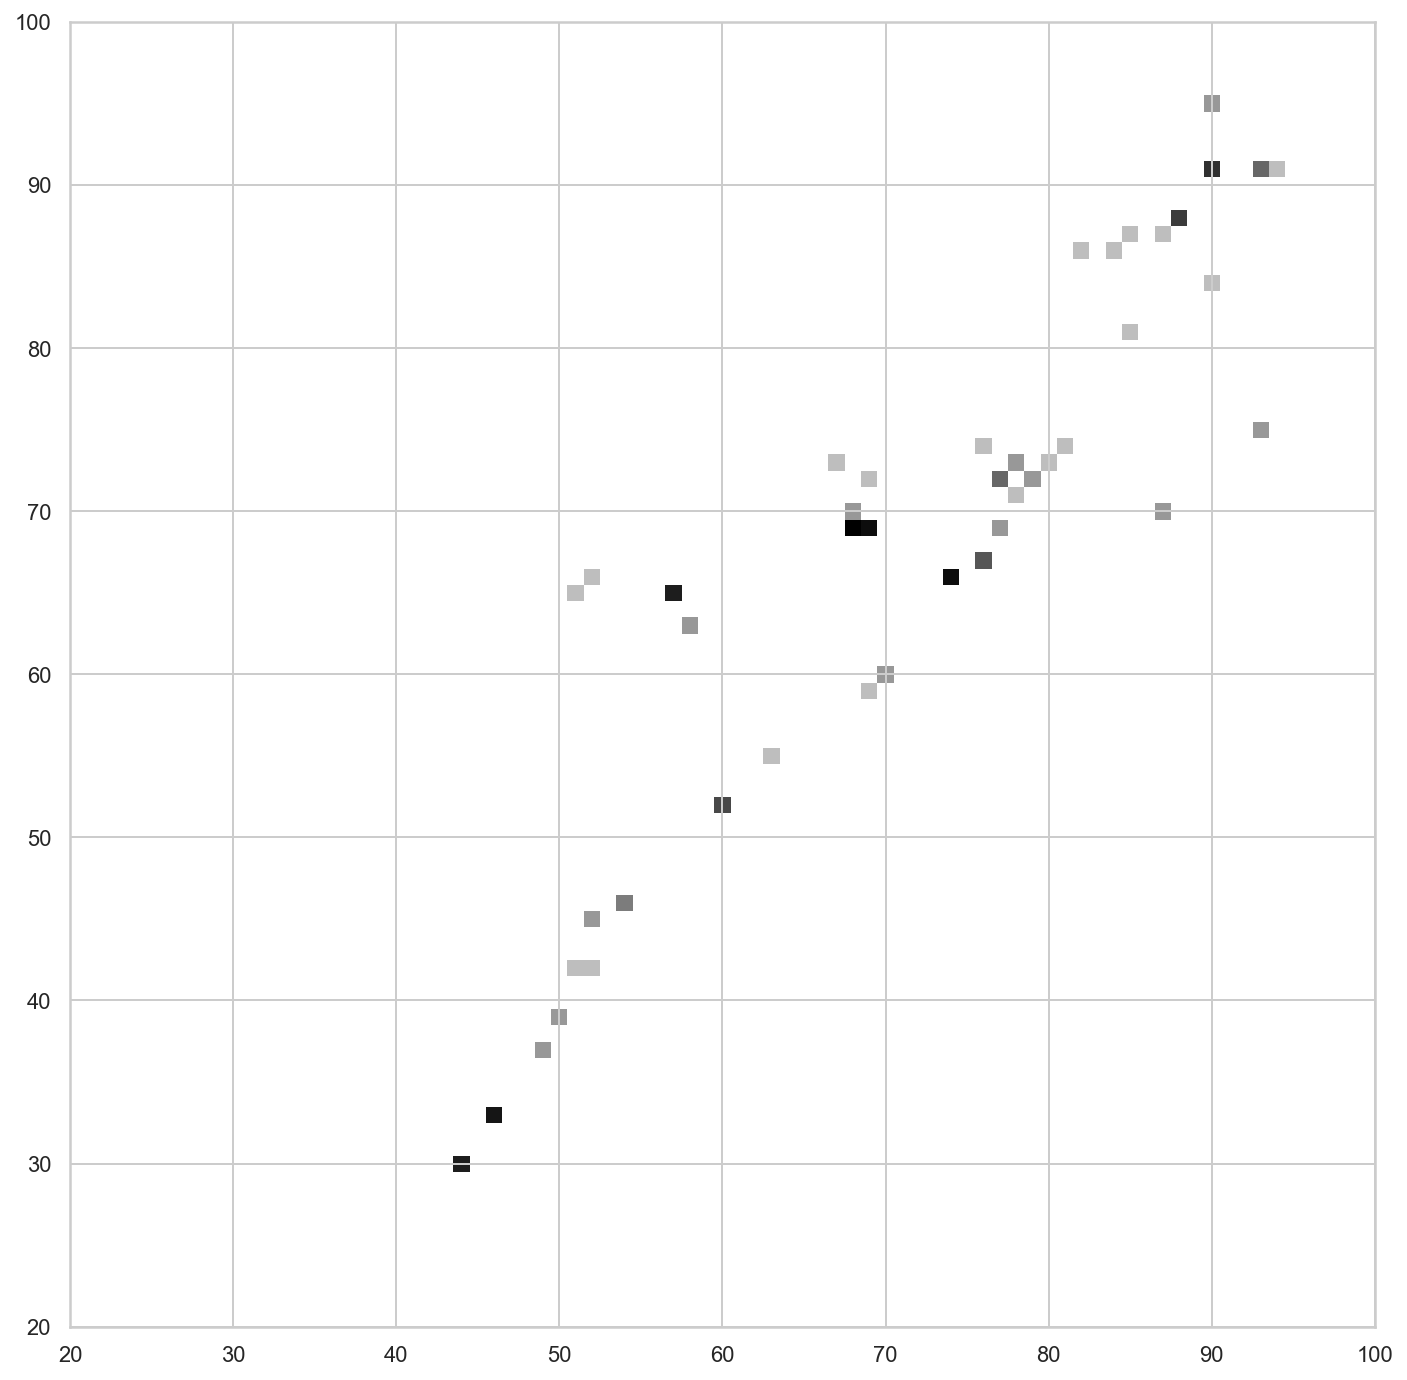

In [18]:
pixel_values = train_dataset[0][0]

plt.figure(figsize=(12, 12))
plt.imshow(-pixel_values[:, :, 2], cmap="gray")
plt.xlim(20, 100)
plt.ylim(20, 100)
plt.show()

### Dataloaders

In [19]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64,
    num_workers=num_workers,
    drop_last=True,
    shuffle=True,
    pin_memory=True,
)

In [20]:
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=64,
    num_workers=num_workers,
    drop_last=False,
    shuffle=False,
    pin_memory=True,
)

### NN architecture

Архитектура состоит из трёх частей. В качестве модели компьютерного зрения возьмём ResNet. Обычно перед подачей изображения в сеть, его нормализуют. Не очень понятно, как это лучше сделать в данном случае, поэтому пусть модель сама учится препроцессингу (хочется, чтобы нули переходили в нули, поэтому `bias=False`). В конце классификатор на каждую локацию из target. Так как позитивных взаимодействий может быть больше одного, используем `Sigmoid`. Удобно, что в качестве функции потерь можно использовать метрику

In [21]:
class GeoModel(pytorch_lightning.LightningModule):
    def __init__(self, train_dataloader, val_dataloader):
        super().__init__()

        self._train_dataloader = train_dataloader
        self._val_dataloader = val_dataloader

        self.preprocess = nn.Sequential(
            nn.Linear(3, 12, False),
            nn.ReLU(),
            nn.Linear(12, 12, False),
            nn.ReLU(),
            nn.Linear(12, 3, False),
        )
        config = ResNetConfig(
            num_channels=3,
            embedding_size=64,
            hidden_sizes=[128, 256, 512, 1024],
            depths=[2, 2, 2, 2],
            layer_type='bottleneck',
            hidden_act='relu',
        )
        self.resnet = ResNetModel(config)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(config.hidden_sizes[-1], len(items_target)),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.preprocess(x)
        output = self.resnet(x.permute(0, 3, 1, 2))
        return self.classifier(output.pooler_output)

    def training_step(self, batch, batch_idx):
        pixel_values, labels = batch

        prediction_scores = self.forward(pixel_values)

        eps = 1e-8
        loss = torch.log(torch.clip(prediction_scores, eps, 1 - eps)) * labels
        loss += torch.log(torch.clip(1 - prediction_scores, eps, 1 - eps)) * (1 - labels)
        loss *= -1.0
        loss = loss.sum(dim=1).mean()

        self.log("train_loss", loss, logger=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pixel_values, labels = batch

        prediction_scores = self.forward(pixel_values)

        eps = 1e-8
        loss = torch.log(torch.clip(prediction_scores, eps, 1 - eps)) * labels
        loss += torch.log(torch.clip(1 - prediction_scores, eps, 1 - eps)) * (1 - labels)
        loss *= -1.0
        loss = loss.sum(dim=1).mean()

        self.log("val_loss", loss, logger=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(), lr=2e-3)
        scheduler = get_linear_schedule_with_warmup(
            optim, num_warmup_steps=0, num_training_steps=20 * len(self._train_dataloader)
        )
        return {
            "optimizer": optim,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
                "strict": True,
            }
        }

    def train_dataloader(self):
        return self._train_dataloader

    def val_dataloader(self):
        return self._val_dataloader

In [22]:
geo_model = GeoModel(train_dataloader, val_dataloader)

In [23]:
print(geo_model) # 5,205,137 параметров

GeoModel(
  (preprocess): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=False)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=False)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=3, bias=False)
  )
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (nor

### Fit

In [24]:
trainer = pytorch_lightning.Trainer(
    accelerator="gpu",
    max_epochs=6, # обучаем 6 эпох, дальше начинается overfit
)
trainer.fit(geo_model)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Save

Сохраним веса и необходимые для инференса значения

In [25]:
trainer.save_checkpoint('./submission/model.ckpt')
np.save("./submission/item2id.npy", item2id)
np.save("./submission/items_target.npy", items_target)
np.save("./submission/xs.npy", xs)
np.save("./submission/ys.npy", ys)